### Install dependencies

In [ ]:
#!pip install datasets tensorboardx transformers

# Clone the repository containing simulation code.
#!git clone https://github.com/MFreidank/Federated_Learning_Workshop_AMLD2021.git

### Set up simulation environment
Using:
- `torch` and `numpy` to perform modelling.
- `tensorboardx` to graph training.
- `pickle` to save trained models.

#### Load `torch` based Federated Learning (FL) functions for our simulation.

In [ ]:
# Load python packages
import os
import sys
import copy
import time
import torch
import pickle
import argparse

import numpy as np
import matplotlib.pyplot as plt

from os import path, getcwd, makedirs
from itertools import islice
from tqdm import tqdm, trange
from tensorboardX import SummaryWriter

# Append `torch_federated_learning` package path.
module_path = path.abspath(path.join('..'))
torch_package_path = "src/torch_federated_learning/"
if module_path not in sys.path:
    sys.path.append(path.join(module_path, torch_package_path))
# Import FL simulation functions from above directory. 
from options import (
    args_parser,
    get_nb_args,
    print_train_stats,
)

from utils import (
    get_dataset, 
    num_batches_per_epoch,
    average_weights, 
    exp_details,
)
from update import (
    test_inference,
    ClientShard,
)
from models import (
    get_model, 
    get_optimizer,
)
# Define path and directory to save trained model and graphs.
save_path = "../save/"
model_save_dir = "objects"
# Load default arguments.
args = get_nb_args()
# Create directory to save trained model weight `.pkl` (pickle) files.
makedirs(path.join(save_path, model_save_dir), exist_ok=True)
# Define paths
path_project = path.abspath('..')
logger = SummaryWriter('../logs')

In [ ]:
# Recommended to use cpu, use GPU when actually performing model training.
#args.gpu = 'cuda:0'

if args.gpu:
    torch.cuda.set_device(args.gpu)
device = 'cuda' if args.gpu else 'cpu'

#### Framework used
`PyTorch` (loaded as `torch`) is an open source machine learning library  
that specializes in tensor computations and GPU acceleration.  

We will be simulating a FL image classification task using the `torch` framework. 

## Part 1: Traditional Computer Vision (CV) training
For this simulation we use a 6 layer Convolutional Neural Network (CNN) model,  
 consisting of 2 convolutional layers, 1 pooling layer and 3 dense layers.  
   [Image of CNN model]  

We train this model on the CIFAR10 dataset which with 6k images per class.  
   [Image depicting overview of CIFAR10]    

### Load model and dataset splits
Using the entire CIFAR10 dataset we make 2 splits: Train and Test in a 50/10 ratio.  

The train set will thus have 50k images.  

The test set will have 10k images held out from both baseline and Federated Learning simulation.

In [ ]:
# Load parse arguments to simulate computer vision.
args = get_nb_args(task="cv")

# Load the CNN model.
args.model = 'cnn'
model = get_model(args)
# Load CIFAR10 dataset stages.
args.dataset = 'cifar'
train_dataset, test_dataset, _ = get_dataset(args)
# Set the model to train and send it to device.
model.to(device)
model.train()

### Set optimizer and criterion
For the traditional training flow we use:
- Stochastic Gradient Descent (SGD) optimizer to train the CNN model.
- Learning rate of 0.01 for training.
- Negative log likelihood loss (criterion) to train.

In [ ]:
# Set optimizer used during model training.
args.optimizer = 'sgd'
args.lr = 0.01
optimizer = get_optimizer(args=args, model=model)
# Set criterion (loss function) to device.
criterion = torch.nn.NLLLoss().to(device)

### Use `DataLoader` to create `trainloader`
Using the `torch.DataLoader` object we can create batches for the training loop.  

Setting a `batch_size` of 64 i.e. 64 images per batch to train the model.  

We also `shuffle` the training data before generating batches for good measure.

In [ ]:
# Using torch.DataLoader, load the training dataset into batches.
trainloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True
)

### Commence model training
Using the `trainloader` which contains generated batches of data,  
we begin the training loop.

In [ ]:
# Set number of epochs to train model on.
args.epochs = 10
# Initiate a list to store epoch losses.
epoch_loss = []
# Iterate through 
for epoch in tqdm(range(args.epochs)):
    # Initiate a list to store losses for every batch.
    batch_loss = []
    # Iterate through batches and for every batch, 
    # perform training pass (forward and backward pass) on CNN model.
    for batch_idx, (images, labels) in enumerate(trainloader):
        # Load the batch images and labels to the device.
        images, labels = images.to(device), labels.to(device)
        # Perform forward pass thorugh model.
        optimizer.zero_grad()
        outputs = model(images)
        # Retrieve loss for the batch.
        loss = criterion(outputs, labels)
        # Using loss value, perform a backward pass on the model.
        loss.backward()
        optimizer.step()
        # For every 50th batch, print training status and loss value.
        if batch_idx % 50 == 0:
            print_train_stats(args=args, epoch=epoch, 
                              batch_idx=batch_idx, images=images, 
                              trainloader=trainloader, loss=loss, 
                              flow_type='baseline')
        # Append batch loss to list.
        batch_loss.append(loss.item())
    # Retrieve average loss on all batches for this epoch. 
    loss_avg = sum(batch_loss) / len(batch_loss)
    # Append epoch loss (average batch loss) to list.
    epoch_loss.append(loss_avg)

# Graph training loss, train accuracy across epochs using `matplotlib`.
plt.figure()
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.xlabel('epochs')
plt.ylabel('Train loss')
plt.savefig('../save/{}_nn_{}_{}_{}.png'.format(
    args.task, args.dataset, args.model, args.epochs))

### Results of training 
Training a single CNN model on 50k CIFAR10 images yielded the following loss curve.    

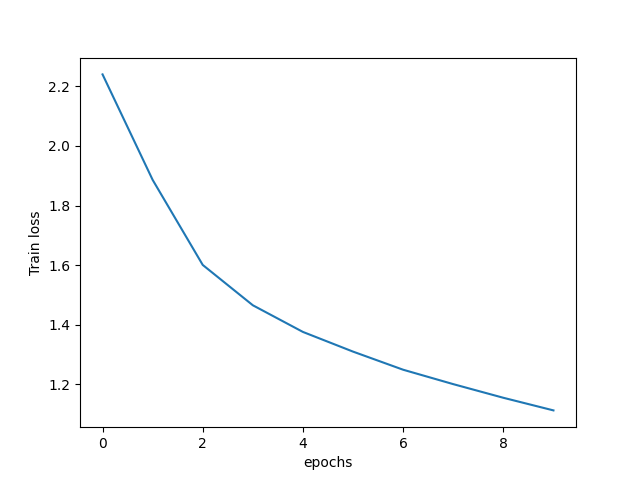

We see the training loss has decreased from ~2 to ~0.8 in 10 epochs of training.

### Evaluate trained model performance using test split
We can now evaluate the performance of this single model on the 10% heldout data => 10k images.

In [ ]:
test_acc, test_loss = test_inference(args=args, model=model, 
                                     test_dataset=test_dataset, device=device)
print('Test on', len(test_dataset), 'samples')
print("Test Accuracy: {:.2f}%".format(100*test_acc)) 

We get Test Accuracy: ~56% with the traditional CV training on CIFAR10 dataset. 

Thus using the traditional Machine Learning flow we were able to train and evaluate a model on a downstream task with relative ease.  

Having all the training and test data centralized allows us to easily tune hyperparameters and evaluate the changes using the test set.

It also allows for better feature extraction and richer data analysis.

### Obstacles in using a traditional supervised ML flow
Simulated datasets only go so far to demonstrate system capabilities in the wild.

Though these datasets are considerably large in size,  
data drift may occur by the time the records have been manually annotated.

Another hurdle is that these datasets (though coming from real world) are usually collected by a single party or organization and may be suscept to bias compared to similar data in the wild.

## Part 2: Simulating training a model on a client-data shard
We now simulate a server sending a global model to a client to be trained on it's data shard.  

We will then send this localloy trained model to other clients for inference to evaluate it's performance.

Lastly, we will evaluate this single-client trained model on the held-out test set.

### Load global model and dataset splits
We load the same CIFAR10 dataset and generate train and test splits identical to the tradional ML flow so that we may compare both the approaches on the same test split.

We also load the inital weights of the global model which will be trained on the client data shards.  
[Image showing global model, client update and global averaging]

#### Simulating FL clients
We will simulate a FL environment assuming data is split identically and independently (i.i.d).  

Creating 50 clients each having 50k/50 =>1k images in their data shards.  

For the initial FL training flow let us the train the global model on only a single client shard for 10 epochs for one global round.

In [ ]:
# Here user groups is a dictionary containing keys for every member (here 50) 
# with subsequent values containing row IDs allocated to that client shard.  

# Setting 50 clients.
args.num_users = 50
# Setting only 1 global round
args.epochs = 1
# Setting 10 epochs on client shard.
args.local_ep = 10
# Setting `frac` to use only one client shard
args.frac = 0.02 # 50 clients x 0.02 sampling fraction => 1 client

# Load dataset splits and user groups.
train_dataset, test_dataset, user_groups = get_dataset(args)
# Load global CNN CV model.
global_model = get_model(args=args, img_size=train_dataset[0][0].shape)

### Prepare FL training flow simulation

In [ ]:
# Set the model to train and send it to device.
global_model.to(device)
# Set the model to train mode 
# (i.e. green flag for model weights to be updated in backward pass).
global_model.train()
# Instatiate a copy of the untrained model weights to be used for Federated Averaging as a base.  
global_weights = global_model.state_dict()

### Simulating client data shard training
Since we are simulating Federated Learning on a single device,  

We use the `ClientShard` object to simulate a client data shard.

We then use `ClientShard.update_weights` function to train the global model on this client chard.

In [ ]:
# Rondomly sample dataset to create client data shards.
idxs_users = np.random.choice(range(args.num_users), 1, replace=False)
# Get our brave clients id.
lonely_client_idx = idxs_users[0]

In [ ]:
# We instatiate our pioneer single client using the idxs returned by the i.i.d sampler.
lonely_client = ClientShard(args=args, 
                            dataset=train_dataset,
                            client_idx=0, #Dummy ID for printing.
                            idxs=user_groups[lonely_client_idx],
                            device=device,
                            logger=logger)
# We can now pass the global model to the client for training, 
# it returns the updated local model and the local training loss.
updated_local_model, loss = lonely_client.update_weights(
    # Here we are passing a copy of the global model to the trainer.
    model=copy.deepcopy(global_model), 
    # Only used for printing purpose.
    global_round=1,
)  

### Evaluating local model on all clients
We now evaluate the average accuracy of the client-trained model on all 50 client-data shards. 

In [ ]:
# Calculate avg training accuracy over local trained model.
list_acc, list_loss = [], []
# Set local model to evaluation mode.
updated_local_model.eval()
# Iterate through all clients.
for idx in range(args.num_users):
    # Instantiate clinet object using sampled IDs.
    client_shard = ClientShard(args=args,
                               dataset=train_dataset,
                               idxs=user_groups[idx],
                               logger=logger)
    # Perform inferencing and evaluate accuracy on client shard.
    acc, loss = client_shard.inference(model=updated_local_model)
    # Append client accuracy and loss.
    list_acc.append(acc)
    list_loss.append(loss)
# Get average accuracy across all 50 clients.
train_accuracy.append(sum(list_acc) / len(list_acc))
print(f' \nAvg Training Stats after 1 global round:')
print(f'Training Loss : {np.mean(np.array(train_loss))}')
print('Train Accuracy: {:.2f}% \n'.format(100 * train_accuracy[-1]))

### Evaluate client trained local model on test split
We can evaluate the local trained model on the heldout 10% test split => 10k images. 

In [ ]:
# Test inference after completion of training
test_acc, test_loss = test_inference(args=args, 
                                     model=updated_local_model, 
                                     test_dataset=test_dataset)
print(f' \n Results after {args.epochs} global rounds of training:')
print("|---- Avg Train Accuracy: {:.2f}%".format(100*train_accuracy[-1]))
print("|---- Test Accuracy: {:.2f}%".format(100*test_acc))

We thus simulated how the server would: 
- Send a model to a client shard to be trained.
- Send the locallly trained model to be evaluated across client shards and on the held-out test set.

## Part 3: Simulate a complete FL training flow
We saw how the server can send a model to clients for training and/or inferencing.

Let us now add some more clients to the mix and train a global model using multiple clients.

### Load global model and dataset splits
We load the global model and sample the data to create client shards as we did in Part 2 for the single client.  

This time let us simulatre 50 clients and use 5 of them for every round of global model training.

We will:
- Train the global model on the client shards for 10 epochs.  
- Use FedAVG to generate an averaged-model using all the client trained models.
- Evaluate the averaged global model on other client shards.
- After multiple global rounds of training, we will evaluate the global model on the held-out test set.

In [ ]:
# Setting 50 clients.
args.num_users = 50
# Setting 10 global rounds
args.epochs = 10
# Setting 10 epochs on client shard.
args.local_ep = 10
# Setting `frac` to use only one client shard
args.frac = 0.1 # 50 clients x 0.1 sampling fraction => 5 clients

# Load dataset and user groups.
train_dataset, test_dataset, user_groups = get_dataset(args)
# Load CV model.
global_model = get_model(args=args, img_size=train_dataset[0][0].shape)

### Prepare FL training flow simulation

In [ ]:
# Set the model to train and send it to device.
global_model.to(device)
# Set the model to train mode 
# (i.e. green flag for model weights to be updated in backward pass).
global_model.train()
# Instatiate a copy of the untrained model weights to be used for Federated Averaging as a base.  
global_weights = global_model.state_dict()
# Instantiate lists to staore global client trained models and losses.
global_train_loss, global_train_accuracy = [], []

### Performing FedAvg training
Now we train a global model on mulitple client-shards and perform FedAVG on the client-trained models.

We do this for 10 global rounds of training and FedAVG'ing.

In [ ]:
exp_details(args)
for epoch in range(args.epochs):
    local_weights, local_losses = [], []
    global_model.train()
    # Randomly sample a fraction of clients and retrieve their ids.
    user_frac = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), 
                                  user_frac, replace=False)
    
    ### Start of client-shard training {{{
    for hidden_client_idx, idx in enumerate(idxs_users):
        client_shard = ClientShard(args=args,
                                   client_idx=hidden_client_idx,
                                   dataset=train_dataset,
                                   idxs=user_groups[idx],
                                   logger=logger,
                                   device=device)
        updated_local_model, loss = client_shard.update_weights(
            model=copy.deepcopy(global_model), 
            global_round=epoch
        )
        local_weights.append(copy.deepcopy(updated_local_model))
        local_losses.append(copy.deepcopy(loss))
    ### }}} End of client-shard training

    # Here we take a list of client-trained models and 
    # perform FedAvg to return a single avreagred global model.
    global_weights = average_weights(local_weights)
    # Update global weights with the averaged model weights.
    global_model.load_state_dict(global_weights)
    
    # Calculate average client-training accuracy.
    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)

    # Calculate avg training accuracy over all users at every epoch
    list_acc, list_loss = [], []
    global_model.eval()
    
    # Remove trained clients from heldout evaluation.
    heldout_clients = list(range(args.num_users))
    for train_client_idx in list(idxs_users):
        heldout_clients.remove(train_client_idx)
    
    ### Start of client evaluation {{{
    for heldout_client_idx, idx in tqdm(enumerate(heldout_clients), 
                                        desc='Evaluating: Hidden client num:', 
                                        total=len(heldout_clients)):
        client_shard = ClientShard(args=args,
                                   client_idx=heldout_client_idx,
                                   dataset=train_dataset,
                                   idxs=user_groups[idx],
                                   logger=logger,
                                   device=device)
        acc, loss = client_shard.inference(model=global_model)
        list_acc.append(acc)
        list_loss.append(loss)
    train_accuracy.append(sum(list_acc) / len(list_acc))
    ### }}} End of client evaluation
    
    # print global training loss after every round.
    if (epoch + 1) % 1 == 0:
        print(f' \nAvg Training Stats after {epoch + 1} global rounds:')
        print(f'Training Loss : {np.mean(np.array(train_loss))}')
        print('Train Accuracy: {:.2f}% \n'.format(100 * train_accuracy[-1]))

We thus trained a global model for 10 global rounds on 5 clients per round with 10 epochs per training client-shard.  

Looking at the global avergae training loss we see some convergence:

<img src="../imgs/fed_cifar_cnn_10_C[0.1]_iid[1]_E[10]_B[8]_loss.png" width="350" height="350" />

We also see that the Training accuracy on held-out clients has improved with global rounds.

<img src="../imgs/fed_cifar_cnn_10_C[0.1]_iid[1]_E[10]_B[8]_acc.png" width="350" height="350" />

### Evaluate global trained model on test split
We can evaluate the global trained model on the heldout 10% test split => 10k images. 

In [ ]:
# Test inference after completion of training
test_acc, test_loss = test_inference(args=args, model=global_model, 
                                     test_dataset=test_dataset, device=device)
print(f' \n Results after {args.epochs} global rounds of training:')
print("|---- Avg Train Accuracy: {:.2f}%".format(100*train_accuracy[-1]))
print("|---- Test Accuracy: {:.2f}%".format(100*test_acc))

We see that the Avg. Train Accuracy is around ~48% and the Test Acuracy is ~47%.

We see that adding more clients (and subsequently more data has led to improvements in the test set. 

## Part 4: Performing FL for Natural Languge Processing

### ADE_corpus_v2
To demonstrate Federate learning on NLP, we use the ADE Adverse Event (AE) classification open-source dataset.  

The dataset contains 23516 records with:  
16695 Non-AE related text &  
6821 AE related text.  

In [ ]:
!cd Federated_Learning_Workshop_AMLD2021 && python src/torch_federated_learning/federated_main.py \
--num_users=50 \
--frac=0.02 \
--task=nlp \
--model=distilbert \
--epochs=10 \
--local_ep=10